# The DMD Functions that get the necessary values and predict future states

In [44]:
import numpy as np
from scipy.sparse.linalg import svds
import math
import pandas as pd
import matplotlib.pyplot as plt

def DMD_Values(X):
    X1 = X[:,:-1]          #Ignores the last column
    Xbar = X[:,1:]         #Ignores the first column
    rows = np.shape(X1)[0]
    cols = np.shape(X1)[1]
    rank = np.linalg.matrix_rank(X1)
    
    ####################################################################################
                                       # IMPORTANT NOTE #
                 # MUST CHANGE THE SVD TO LINALG FOR NUMERICAL WEATHER DATA AND #
                                # CHANGE TO SPARSE SVDS FOR THE IMAGE DATA #
    ####################################################################################
    
    u, s, vh = svds(X1, k = rank-1)     #Use for Images Dataset
    #u, s, vh = np.linalg.svd(X1)       #Compute SVD for numerical
    v = np.transpose(vh)   
    ur =  u[:,:rank]                 #first r columns of u
    vr =  v[:,:rank]                 #first r columns of v
    s = np.diag(s)
    sr = s[:rank, :rank]
    
    ustar = np.transpose(ur)
    Xpseudo = np.linalg.pinv(X1)
    
    #Solving for Ar
    #Ar = np.dot(ustar, np.dot(Xbar, np.dot(Xpseudo, ur)))
    Ar = np.dot(np.dot(np.dot(ustar, Xbar), Xpseudo), ur)
    
    #Getting eigenvalues and eigenvectors of Ar
    L, W = np.linalg.eig(Ar)
    
    #Get Inverse of Sigma for calculation of PHI
    sInv = np.linalg.inv(sr)
    
    #PHI = np.dot(Xbar, np.dot(vr, np.dot(sInv, W)))
    PHI = np.dot(np.dot(np.dot(Xbar, vr), sInv), W)
    
    B = np.dot(np.linalg.pinv(PHI), X1[:,0])
    
    return rank, L, W, PHI, B

def DMD_Predict(k, L, PHI, B, rank):
    X_k = 0 # initializes X_k
    for j in range(rank-1):
        X_k = X_k + np.dot(np.dot(PHI[:,j], L[j]**(k-1)), B[j])
    return X_k

## Loop that reconstructs the entire dataset 15 columns at a time so that DMD does not Fail

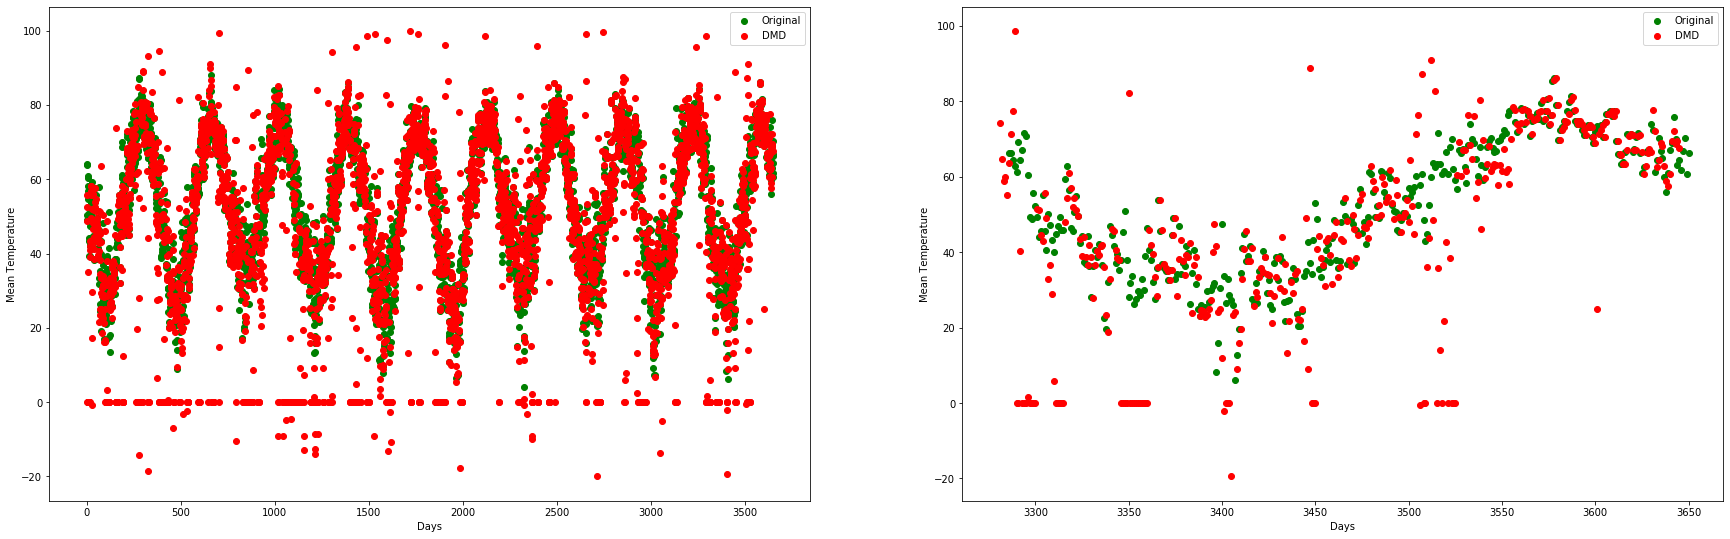

In [9]:
df = pd.read_csv("WCA_Historical_Data.csv")
dates = df.columns[1:]
newDF = df.select_dtypes(['number'])
X = newDF.values
X = X[:,:]

masterX = np.array([0])

#SPLITS UP ARRAY AND PERFORMS DMD ON EACH SMALLER SET

for i in range(0,X[0].size-15, 15):
    
    testX = X[:, i:i+15]
    
    rank, L, W, PHI, B = DMD_Values(testX)
    
    for i in range(1, testX[0].size+1):
        X_k = DMD_Predict(i, L, PHI, B, rank)
        if i == 1:
            X_k_temps = X_k[0]
        else:
            X_k_temps = np.append(X_k_temps,X_k[0])
        
    masterX = np.append(masterX, X_k_temps)
    

#TRANSFORMS EXTREME OUTLIERS TO 0 SO GRAPH WILL SHOW RESULTS

for i in range(masterX.size):
    if abs(masterX[i]) > 100 or masterX[i] < -20:
        masterX[i] = 0  #np.mean((masterX[i-1],masterX[i-2]))
        
    
#PLOTS THE RECONSTRUCTION

fig = plt.figure(figsize=[30,20])
#Entire 10 year plot
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(np.arange(0,X[0].size), X[0], color = 'green', label = "Original")
ax1.scatter(np.arange(0,masterX.size), masterX.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Mean Temperature')
plt.legend(loc = 'upper right')

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(np.arange(X[0].size - 365, X[0].size), X[0,-365:], color = 'green', label = "Original")
ax2.scatter(np.arange(masterX.size - 365,masterX.size), masterX[-365:].real, color = 'red', label = "DMD")
ax2.set_xlabel('Days')
ax2.set_ylabel('Mean Temperature')
plt.legend(loc = 'upper right')

## Below is a 10 day prediction based off the last 15 recorded measurements 

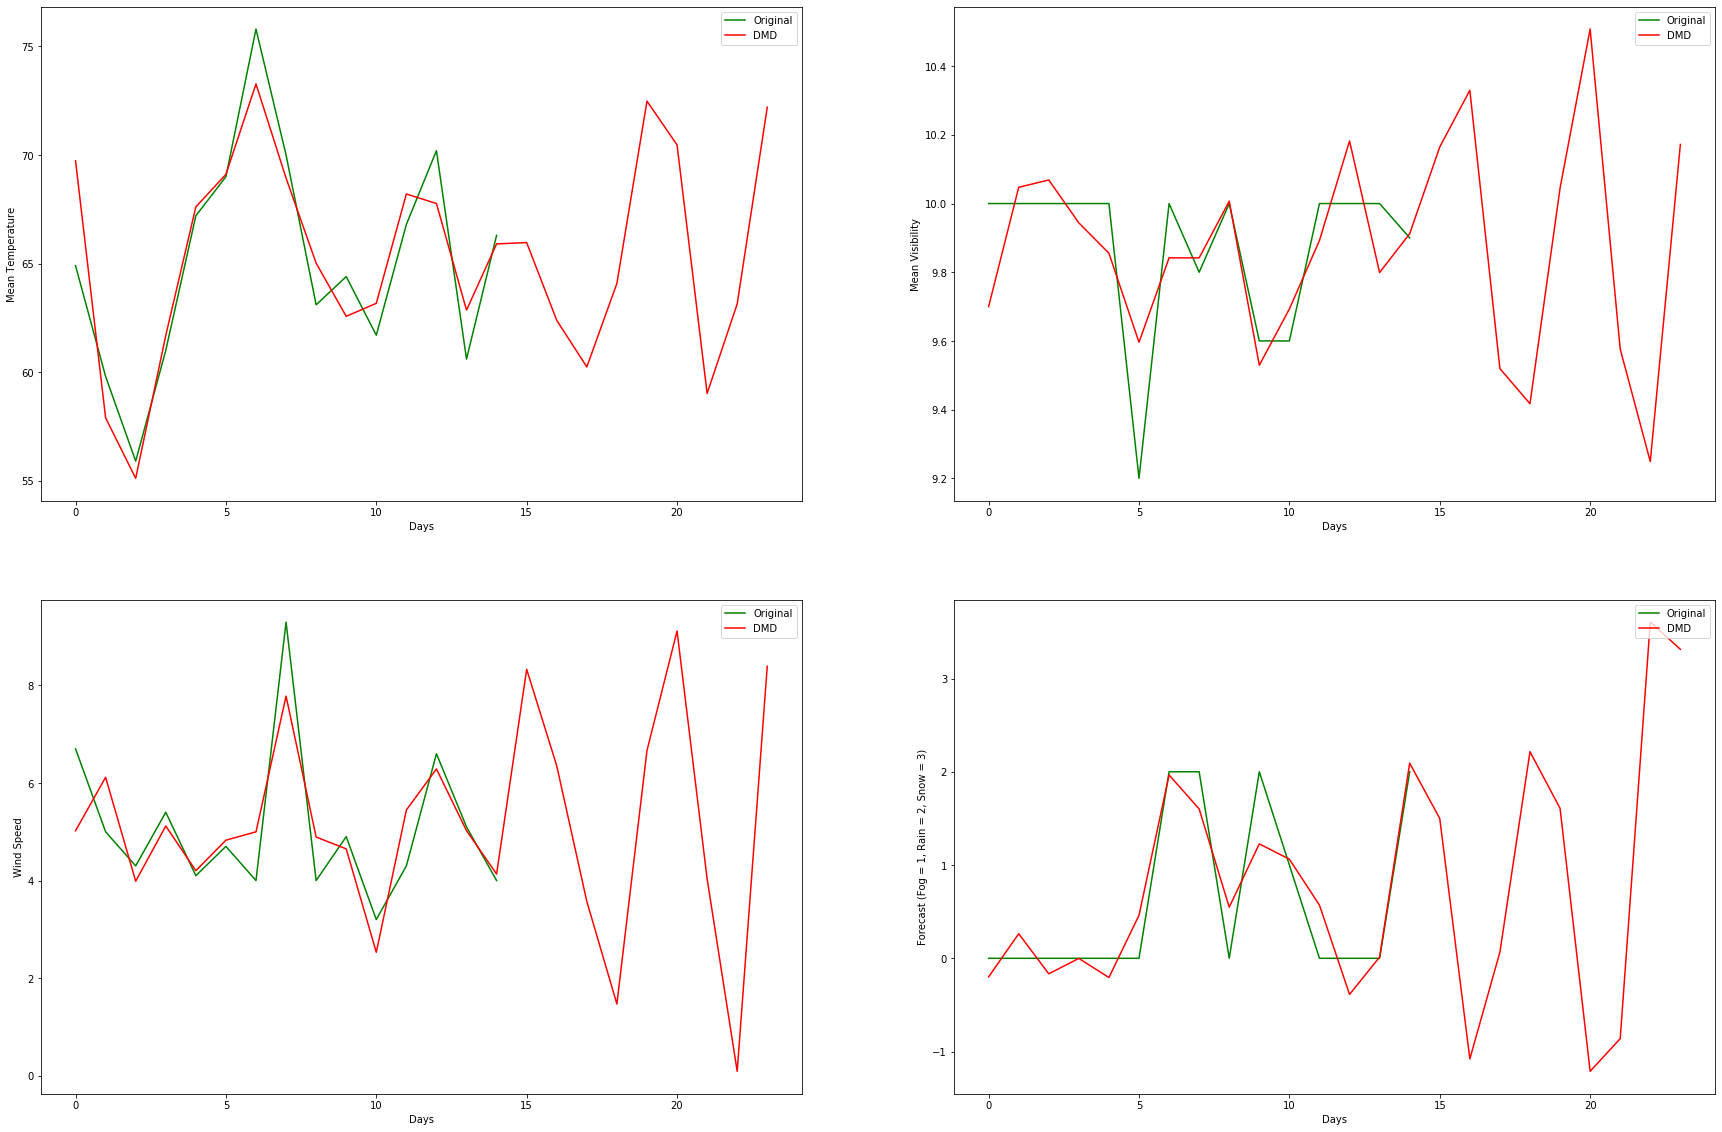

In [12]:
df = pd.read_csv("WCA_Historical_Data.csv")
dates = df.columns[1:]
newDF = df.select_dtypes(['number'])
X = newDF.values
X = X[:, -15:]
rank = np.linalg.matrix_rank(X)

#GETS VALUES TO PREDICT

rank, L, W, PHI, B = DMD_Values(X)


#PREDICTS 10 DAYS INTO FUTURE

for i in range(1, X[0].size+10):
    X_k = DMD_Predict(i, L, PHI, B, rank)
    if i == 1:
        X_k_temps = X_k[0]
        X_k_visibility = X_k[8]
        X_k_wind = X_k[10]
        X_k_forecast = X_k[16]
    else:
        X_k_temps = np.append(X_k_temps,X_k[0])
        X_k_visibility = np.append(X_k_visibility,X_k[8])
        X_k_wind = np.append(X_k_wind,X_k[10])
        X_k_forecast = np.append(X_k_forecast,X_k[16])
        
        
#PLOTS THE RESULTS     
        
fig = plt.figure(figsize=[30,20])
#Entire 10 year plot
ax1 = fig.add_subplot(2,2,1)
ax1.plot(np.arange(0,X[0].size), X[0], color = 'green', label = "Original")
ax1.plot(np.arange(0,X_k_temps.size), X_k_temps.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Mean Temperature')
plt.legend(loc = 'upper right')

ax1 = fig.add_subplot(2,2,2)
ax1.plot(np.arange(0,X[8].size), X[8], color = 'green', label = "Original")
ax1.plot(np.arange(0,X_k_visibility.size), X_k_visibility.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Mean Visibility')
plt.legend(loc = 'upper right')

ax1 = fig.add_subplot(2,2,3)
ax1.plot(np.arange(0,X[10].size), X[10], color = 'green', label = "Original")
ax1.plot(np.arange(0,X_k_wind.size), X_k_wind.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Wind Speed')
plt.legend(loc = 'upper right')

ax1 = fig.add_subplot(2,2,4)
ax1.plot(np.arange(0,X[16].size), X[16], color = 'green', label = "Original")
ax1.plot(np.arange(0,X_k_forecast.size), X_k_forecast.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Forecast (Fog = 1, Rain = 2, Snow = 3)')
plt.legend(loc = 'upper right')

plt.show()

## Here is a prediction of known values to check the accuracy of DMD

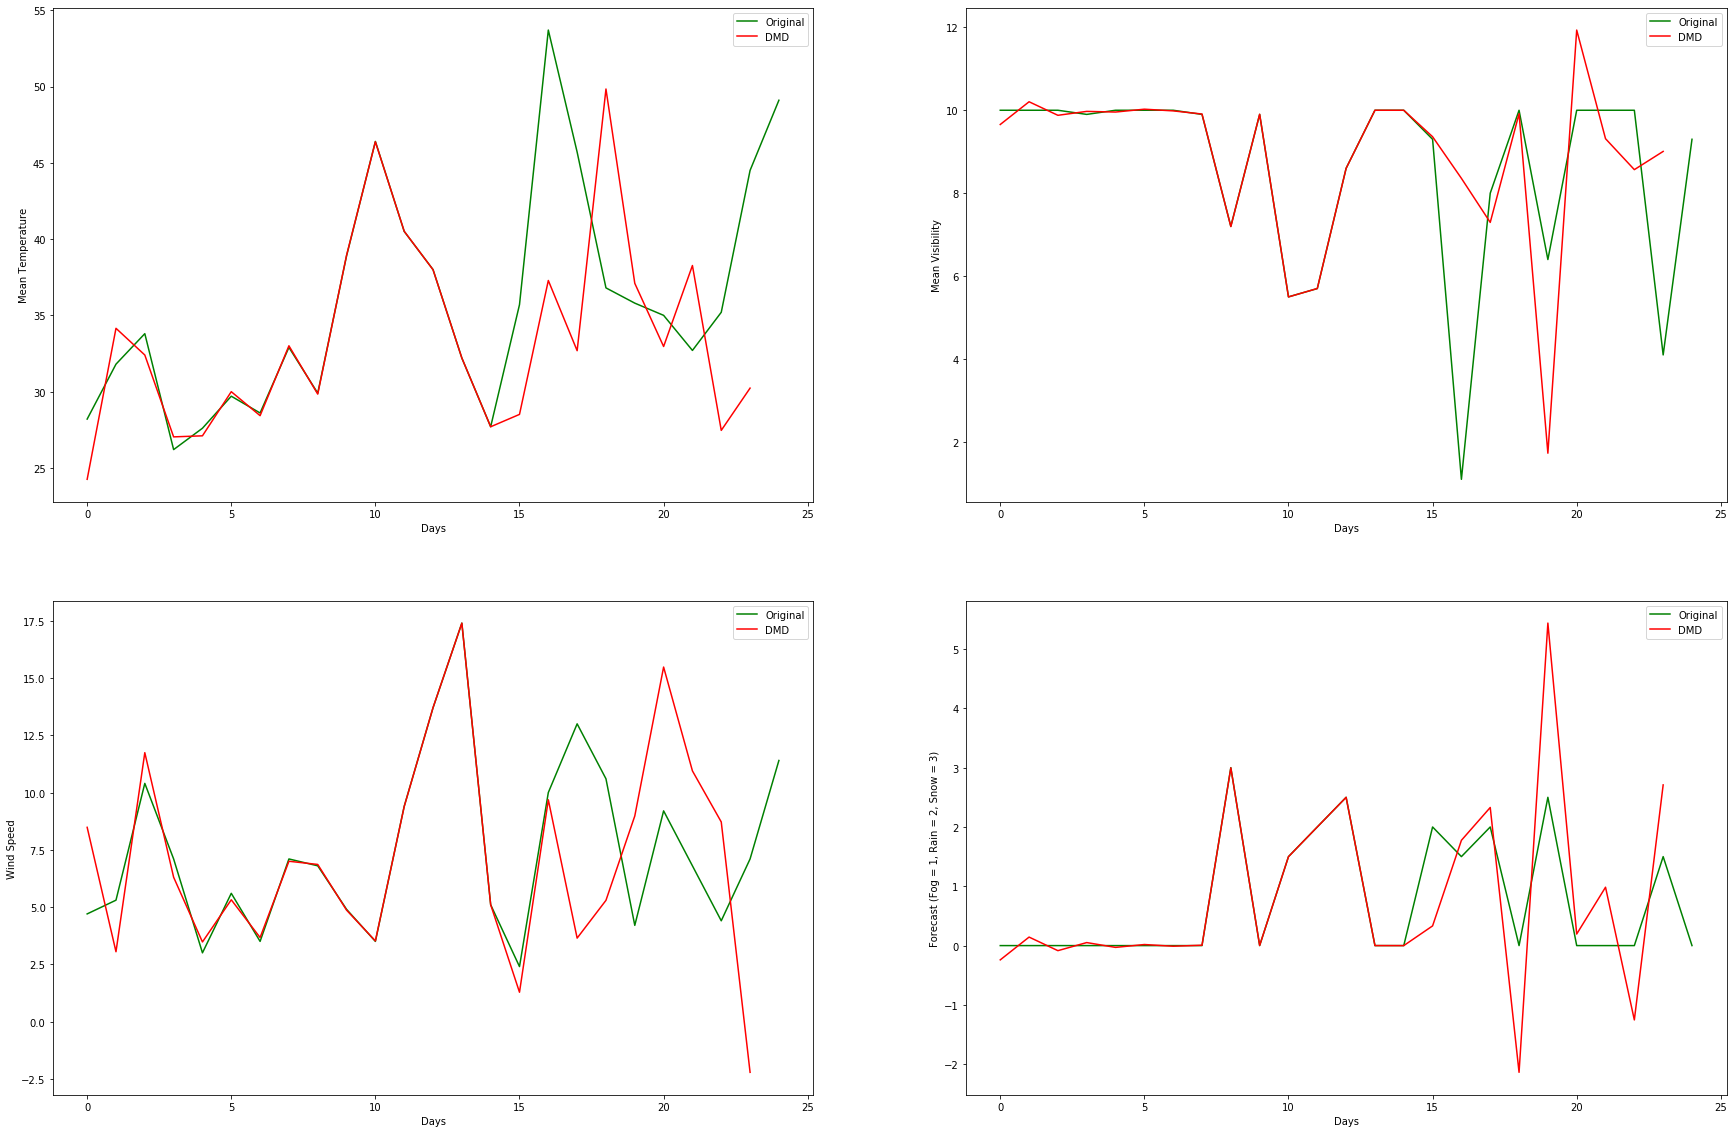

In [14]:
df = pd.read_csv("WCA_Historical_Data.csv")
dates = df.columns[1:]
newDF = df.select_dtypes(['number'])
X = newDF.values
checkX = X[:, 3350:3375]
X = X[:, 3350:3365]
rank = np.linalg.matrix_rank(X)


#GETS VALUES TO PREDICT

rank, L, W, PHI, B = DMD_Values(X)


#PREDICTS 10 DAYS INTO FUTURE

for i in range(1, X[0].size+10):
    X_k = DMD_Predict(i, L, PHI, B, rank)
    if i == 1:
        X_k_temps = X_k[0]
        X_k_visibility = X_k[8]
        X_k_wind = X_k[10]
        X_k_forecast = X_k[16]
    else:
        X_k_temps = np.append(X_k_temps,X_k[0])
        X_k_visibility = np.append(X_k_visibility,X_k[8])
        X_k_wind = np.append(X_k_wind,X_k[10])
        X_k_forecast = np.append(X_k_forecast,X_k[16])
        
        
#PLOTS THE RESULTS  

fig = plt.figure(figsize=[30,20])
#Entire 10 year plot
ax1 = fig.add_subplot(2,2,1)
ax1.plot(np.arange(0,checkX[0].size), checkX[0], color = 'green', label = "Original")
ax1.plot(np.arange(0,X_k_temps.size), X_k_temps.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Mean Temperature')
plt.legend(loc = 'upper right')

ax1 = fig.add_subplot(2,2,2)
ax1.plot(np.arange(0,checkX[8].size), checkX[8], color = 'green', label = "Original")
ax1.plot(np.arange(0,X_k_visibility.size), X_k_visibility.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Mean Visibility')
plt.legend(loc = 'upper right')

ax1 = fig.add_subplot(2,2,3)
ax1.plot(np.arange(0,checkX[10].size), checkX[10], color = 'green', label = "Original")
ax1.plot(np.arange(0,X_k_wind.size), X_k_wind.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Wind Speed')
plt.legend(loc = 'upper right')

ax1 = fig.add_subplot(2,2,4)
ax1.plot(np.arange(0,checkX[16].size), checkX[16], color = 'green', label = "Original")
ax1.plot(np.arange(0,X_k_forecast.size), X_k_forecast.real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Forecast (Fog = 1, Rain = 2, Snow = 3)')
plt.legend(loc = 'upper right')

plt.show()

## Here is the formulation and graph of Ar

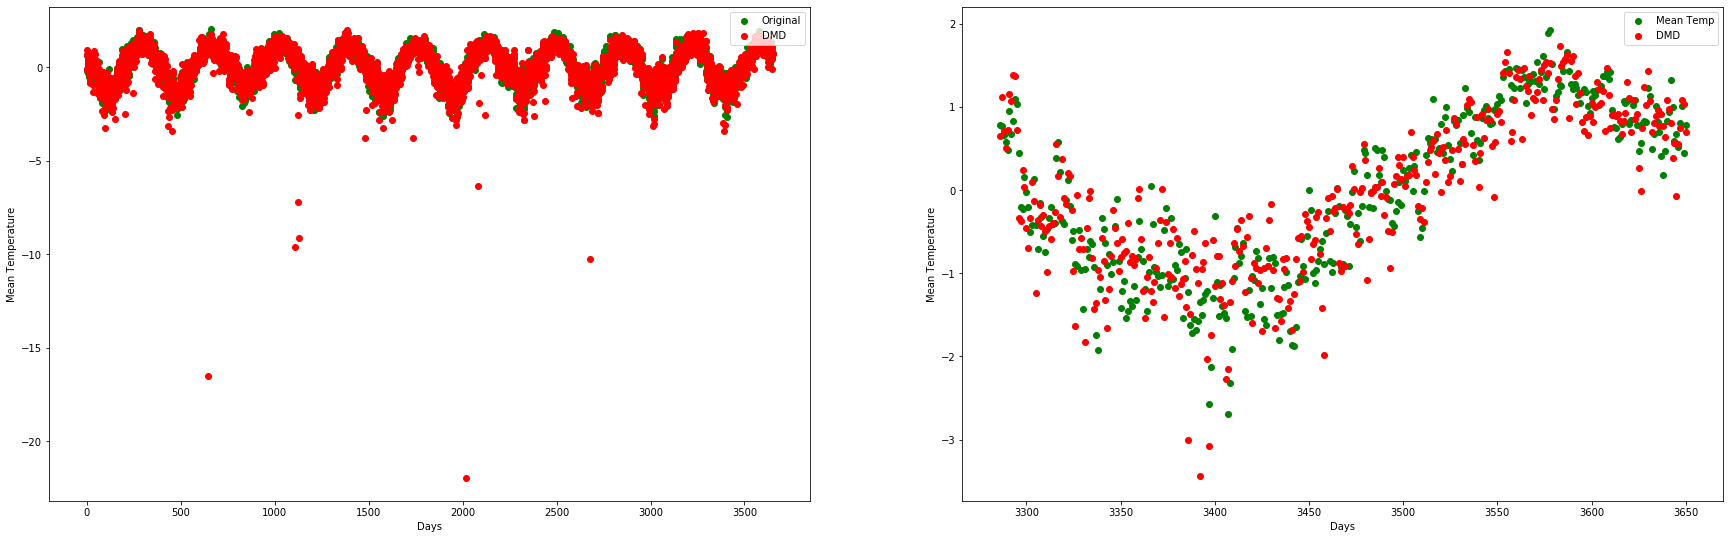

In [86]:
df = pd.read_csv("WCA_Historical_Data_Normalized.csv")
dates = df.columns[1:]
newDF = df.select_dtypes(['number'])
X = newDF.values
X = X[:, :]
rank = np.linalg.matrix_rank(X)


#Basically the DMD_Value Function
####################
X1 = X[:,:-1]          #Ignores the last column
Xbar = X[:,1:]         #Ignores the first column
rows = np.shape(X1)[0]
cols = np.shape(X1)[1]
rank = np.linalg.matrix_rank(X1)
    
u, s, vh = np.linalg.svd(X1)     #Compute SVD
v = np.transpose(vh)   
ur =  u[:,:rank]                 #first r columns of u
vr =  v[:,:rank]                 #first r columns of v
s = np.diag(s)
sr = s[:rank, :rank]
    
ustar = np.transpose(ur)
Xpseudo = np.linalg.pinv(X1)
    
#Solving for Ar
Ar = np.dot(ustar, np.dot(Xbar, np.dot(Xpseudo, ur)))
    
#Getting eigenvalues and eigenvectors of Ar
L, W = np.linalg.eig(Ar)
    
#Get Inverse of Sigma for calculation of PHI
sInv = np.linalg.inv(sr)
    
#PHI = np.dot(Xbar, np.dot(vr, np.dot(sInv, W)))
PHI = np.dot(np.dot(np.dot(Xbar, vr), sInv), W)
    
B = np.dot(np.linalg.pinv(PHI), X1[:,0])
#####################

newX = np.dot(Ar, X)

fig = plt.figure(figsize=[30,20])
#Entire 10 year plot
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(np.arange(0,X[0].size), X[0], color = 'green', label = "Original")
ax1.scatter(np.arange(0, newX[0].size), newX[0], color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Mean Temperature')
plt.legend(loc = 'upper right')

#Last one year Plot
ax2 = fig.add_subplot(2,2,2)
ax2.scatter(np.arange(X[0].size - 365, X[0].size), X[0,-365:], color = 'green', label = "Mean Temp")
ax2.scatter(np.arange(X[0].size - 365, X[0].size), newX[0,-365:], color = 'red', label = "DMD")
ax2.set_xlabel('Days')
ax2.set_ylabel('Mean Temperature')
plt.legend(loc = 'upper right')

plt.show()

## This is the code used to augment the data. Results are left out here because it took a very long time to run

In [ ]:
#df = pd.read_csv("WCA_Historical_Data_Normalized.csv")
#dates = df.columns[1:]
#newDF = df.select_dtypes(['number'])
#X = newDF.values
#for i in range(50):
#    if i == 0:
#        Xa = np.vstack((X,np.hstack((X[:,i:],np.zeros((17,i))))))
#    else:
#        Xa = np.vstack((Xa,np.hstack((X[:,i:],np.zeros((17,i))))))
#X = Xa[:,:-50]

## Working with Water Vapor Images

In [83]:
from PIL import Image

df = pd.read_csv("picture_array.csv", header = None)
X = df.values
X = X[:,:]

#SET NUMBER OF PREDICTIONS
numPredictions = 6

rank, L, W, PHI, B = DMD_Values(X)

for i in range(1, X[0].size+numPredictions):
    X_k = DMD_Predict(i, L, PHI, B, rank)
    if i == 1:
        X_k_data = X_k
        X_k_data = X_k_data.reshape(-1,1)
    else:
        X_k_data = np.hstack((X_k_data,X_k.reshape(-1,1)))
        
#NOW WE HAVE THE DMD DATA

In [72]:
#SHOW A SINGLE IMAGE FROM THE ORIGINAL DATA
originalcol = np.asarray(X[:,34]).reshape((300,500,3))
originalcol = originalcol.astype("uint8")
imv2 = Image.fromarray(originalcol)
imv2.show()

In [85]:
#CONSTRUCT ANIMATION LIST FOR ORIGINAL DATA

from PIL import Image
images = []

for i in range(X[0].size):
    newcol = X[:,i].real.reshape((300,500,3))
    newcol = newcol.astype("uint8")
    im = Image.fromarray(newcol)
    #im.show()
    images.append(im)

In [84]:
#CONSTRUCT ANIMATION LIST FOR RECONSTRUCTED DATA

from PIL import Image
Rimages = []

for i in range(X_k_data[0].size):
    newcol = X_k_data[:,i].real.reshape((300,500,3))
    newcol = newcol.astype("uint8")
    im = Image.fromarray(newcol)
    #im.show()
    Rimages.append(im)

In [67]:
#Save a single image

#imv2.save("C:/Users/MikeCamp/Desktop/WaterVaporImages/1.png",format="PNG") 

In [82]:
#Save GIF for Original Data

#images[0].save('C:/Users/MikeCamp/Desktop/WaterVaporImages/Originalweather.gif', save_all=True, append_images=images[1:],loop=5)

In [ ]:
#Save Gif for Reconstructed Data

#Rimages[0].save('C:/Users/MikeCamp/Desktop/WaterVaporImages/Reconstructedweather.gif', save_all=True, append_images=Rimages[1:],loop=5)

## Here is plain PyDMD results

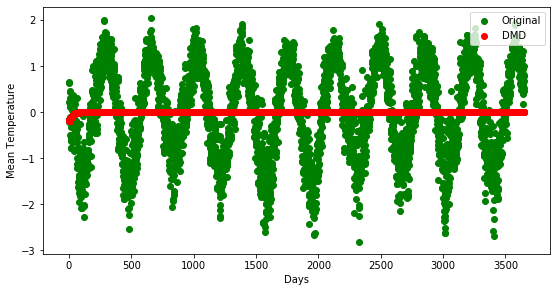

In [20]:
import pydmd 

df = pd.read_csv("WCA_Historical_Data_Normalized.csv")
dates = df.columns[1:]
newDF = df.select_dtypes(['number'])
X = newDF.values
X = X[:, :]

dmd = pydmd.DMD(svd_rank=0)
dmd.fit(X)

fig = plt.figure(figsize=[20,10])
#Entire 10 year plot
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(np.arange(0,X[0].size), X[0], color = 'green', label = "Original")
ax1.scatter(np.arange(0, dmd.reconstructed_data[0].size), dmd.reconstructed_data[0].real, color = 'red', label = "DMD")
ax1.set_xlabel('Days')
ax1.set_ylabel('Mean Temperature')
plt.legend(loc = 'upper right')

plt.show()

## PyDMD - Higher Order DMD

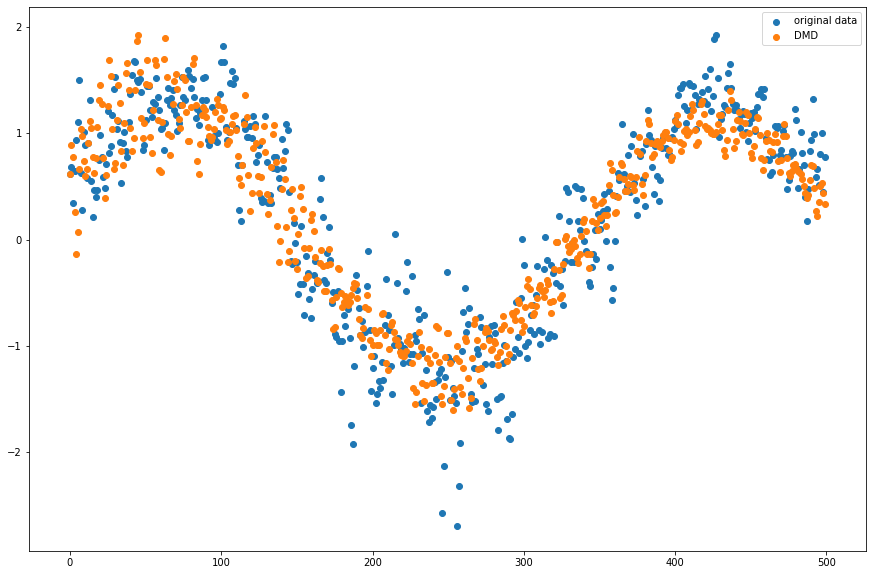

In [27]:
import pydmd

df = pd.read_csv("WCA_Historical_Data_Normalized.csv")
dates = df.columns[1:]
newDF = df.select_dtypes(['number'])
X = newDF.values
X = X[:,-500:]
rank = np.linalg.matrix_rank(X)

#MEAN SQUARE ERROR FUNCTION
def fmse(A, Ak):
    mse = ((A - Ak)**2).mean(axis=None)
    
    return mse


#FIND THE BEST d VALUE FOR HODMD
min_mse = 10000000

for i in range(20, X[0].size):
    hodmd = pydmd.HODMD(svd_rank=0, d=i)
    hodmd.fit(X)
    
    mse = fmse(X[0], hodmd.reconstructed_data[0].real)
    
    if (mse < min_mse):
        min_mse = mse
        min_index = i

        
#FIT THE DATA
hodmd = pydmd.HODMD(svd_rank=0, d=min_index)
hodmd.fit(X)
#hodmd.plot_eigs()


#PLOT THE RECONSTRUCTED DATA
fig = plt.figure(figsize=[15,10])

plt.scatter(hodmd.original_timesteps, X[0], label="original data")
plt.scatter(hodmd.dmd_timesteps, hodmd.reconstructed_data[0].real, label="DMD")
plt.legend(loc = 'upper right')

plt.show()